In [1]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm.auto import tqdm

input_duration=3


In [2]:
# Data Directory
dir_list = os.listdir('data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1


In [4]:
print (len(data_df))
data_df.head()


1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1
4,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2


In [5]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples


data/Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [6]:
len(samples), sample_rate

(77989, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
sample_rate/ len(samples)

0.28273218017925605

Text(0.5, 0, 'Seconds')

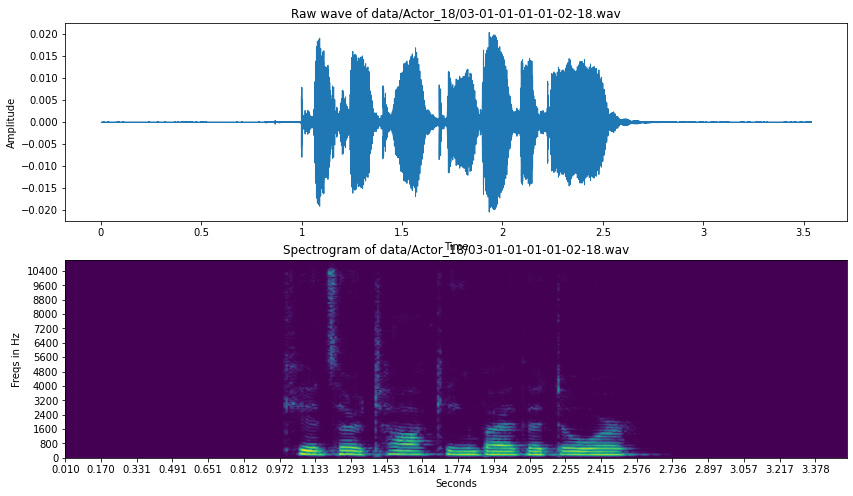

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std


In [11]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-1.9141038e-07, -4.1607140e-07,  2.0688096e-06, ...,
         5.6699279e-05,  2.1195672e-05,  3.1794041e-06], dtype=float32),
 array([20992, 58880]))

C:\Users\MAYANK\AppData\Local\Temp/ipykernel_43300/2009969926.py:2: FutureWarning:

Pass y=[-1.9141038e-07 -4.1607140e-07  2.0688096e-06 ...  5.6699279e-05
  2.1195672e-05  3.1794041e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error



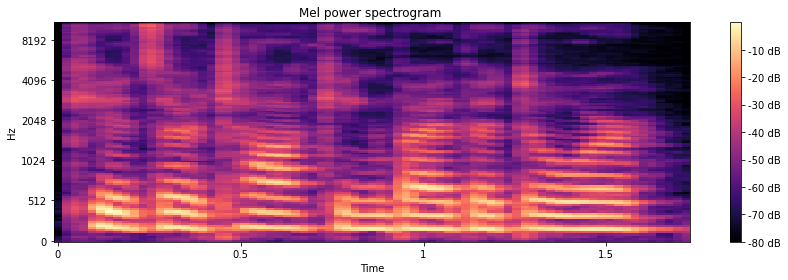

In [12]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


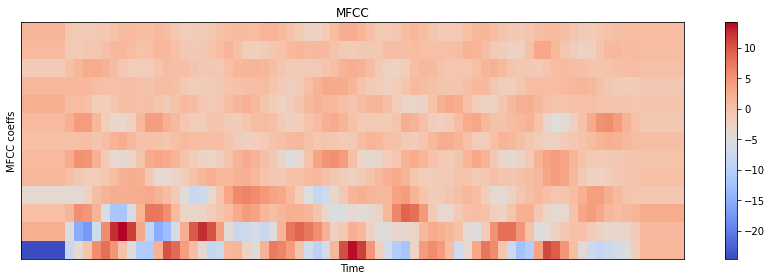

In [13]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()


In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)


In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)


In [16]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)


In [17]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)


1440

In [18]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)


1440

In [19]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)


1440

In [20]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)


1440

In [21]:
# Selecting the label set we want by commenting the unwanteds.

# data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
data_df['label'] = label8_list
data_df.head()


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_neutral
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1,male_neutral
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1,male_neutral
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1,male_neutral
4,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_calm


In [22]:
print (data_df.label.value_counts().keys())

Index(['male_calm', 'male_happy', 'male_sad', 'male_angry', 'male_fearful',
       'male_disgust', 'male_surprised', 'female_calm', 'female_happy',
       'female_sad', 'female_angry', 'female_fearful', 'female_disgust',
       'female_surprised', 'male_neutral', 'female_neutral'],
      dtype='object')


In [23]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


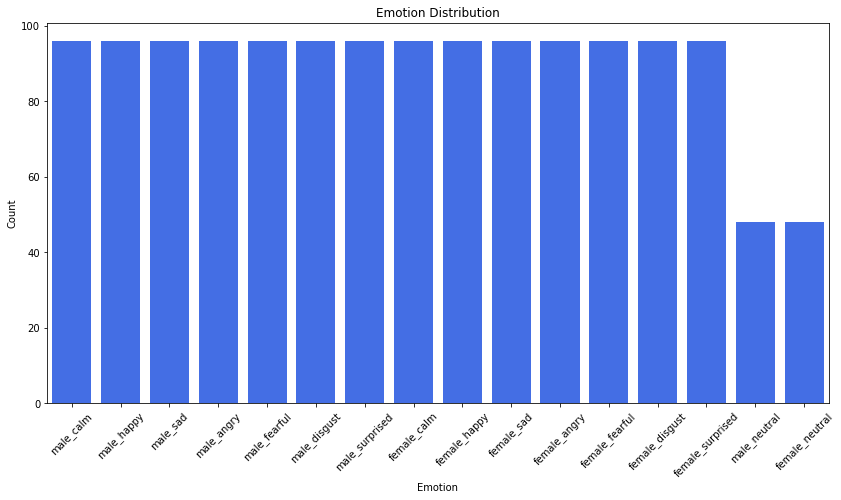

In [24]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")


In [25]:
# male Data Set


# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1,tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()


In [26]:
# FeMale Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_disgust"]
data2_df = data2_df[data2_df.label != "female_surprised"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()


600


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_neutral
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1,male_neutral
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1,male_neutral
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1,male_neutral
4,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_calm


In [27]:
print (len(data3_df))
data3_df.head()


120


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_21/03-01-01-01-01-01-21.wav,1,21,male,0,0,0,1,male_neutral
1,data/Actor_21/03-01-01-01-01-02-21.wav,1,21,male,0,0,1,1,male_neutral
2,data/Actor_21/03-01-01-01-02-01-21.wav,1,21,male,0,1,0,1,male_neutral
3,data/Actor_21/03-01-01-01-02-02-21.wav,1,21,male,0,1,1,1,male_neutral
4,data/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,0,2,male_calm


In [28]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]


  0%|          | 0/600 [00:00<?, ?it/s]

In [29]:
data.head()

,feature
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-63.190464, -62.799866, -63.830635, -60.55258..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."


In [30]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label


In [31]:
newdf = pd.concat([df3,labels], axis=1)

In [32]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)


600

In [33]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
1,-63.190464,-62.799866,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm
5,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.127113,-67.557388,male_calm
6,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_calm
7,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN,male_calm
8,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_calm
9,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-57.185970,-61.188725,-67.108391,-67.508125,-66.245537,-68.733047,-69.243256,-69.243256,-69.243256,male_calm


In [34]:
rnewdf.isnull().sum().sum()

4024

In [35]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-63.190464,-62.799866,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.95771,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm


In [36]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data


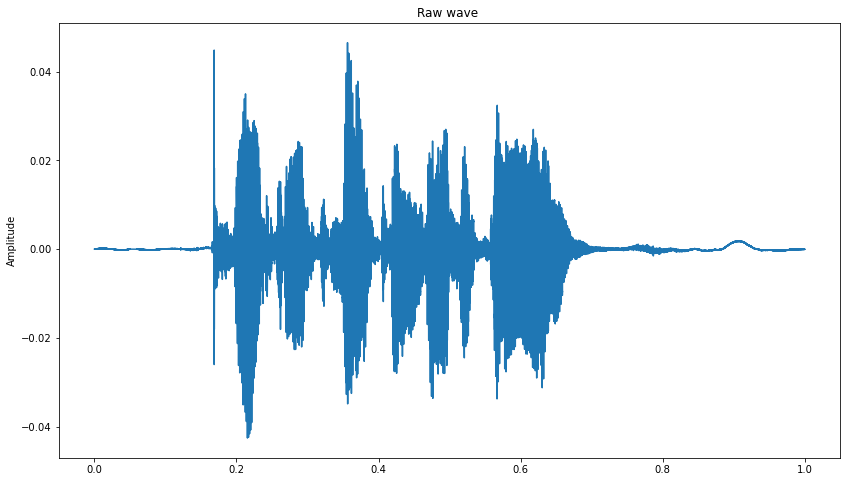

In [37]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)


C:\Users\MAYANK\AppData\Local\Temp/ipykernel_43300/2150942695.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error



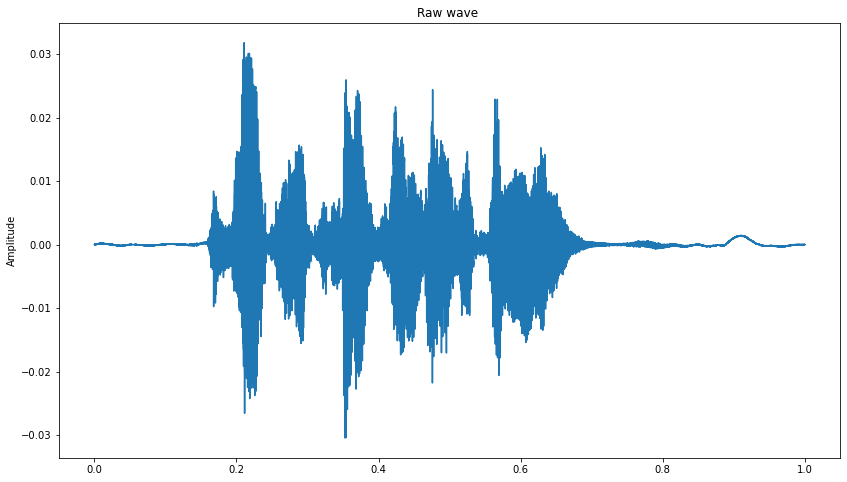

In [38]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)


In [39]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]


  0%|          | 0/600 [00:00<?, ?it/s]

In [40]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]


  0%|          | 0/600 [00:00<?, ?it/s]

C:\Users\MAYANK\AppData\Local\Temp/ipykernel_43300/2150942695.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error



In [41]:
len(syn_data1), len(syn_data2)

(600, 600)

In [42]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)


In [43]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)


600

In [44]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-60.391278,-56.872994,-57.812510,-56.003528,-56.137335,-56.384895,-57.529909,-57.899625,-55.370629,-56.292009,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,male_neutral
1,-56.400166,-53.114571,-53.598420,-52.789931,-52.946261,-52.626002,-51.288405,-50.568260,-51.600181,-52.891368,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,male_neutral
2,-50.870383,-50.745227,-52.906142,-53.389945,-50.000291,-47.703314,-50.813173,-49.069125,-50.761342,-50.676220,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,male_neutral
3,-50.440129,-47.727541,-48.205493,-47.314203,-48.411191,-48.941486,-49.500301,-48.989101,-48.593260,-49.962342,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,male_neutral
4,-63.452784,-61.942184,-59.352432,-60.181568,-61.613603,-59.501275,-59.154745,-59.263089,-58.410266,-56.206155,...,-59.18829,-59.084351,-57.652901,-59.025357,-59.74954,-58.1549,-58.184433,-59.223657,-61.274333,male_calm


In [45]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)


600

In [46]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-63.190464,-62.799866,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.95771,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm


In [47]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [48]:
y_train.value_counts()

male_sad          192
male_surprised    192
male_happy        192
male_angry        192
male_calm         192
male_disgust      192
male_fearful      192
male_neutral       96
Name: label, dtype: int64

In [49]:
y_test.value_counts()

male_angry        48
male_surprised    48
male_fearful      48
male_disgust      48
male_sad          48
male_calm         48
male_happy        48
male_neutral      24
Name: label, dtype: int64

In [50]:
X_train.isna().sum().sum()

0

In [51]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


In [52]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)


In [53]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [54]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.Adam(lr=0.00001, decay=1e-6)

C:\Users\MAYANK\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [86]:
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])
# model.summary()

In [56]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

In [57]:
print(x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape)

(1440, 259, 1) (1440, 8) (360, 259, 1) (360, 8)


In [58]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=216, epochs=700, 
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Epoch 1/700
7/7 [==============================] - 6s 682ms/step - loss: 2.9503 - accuracy: 0.1444 - fscore: 0.0000e+00 - val_loss: 2.5396 - val_accuracy: 0.1361 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/700
7/7 [==============================] - 4s 617ms/step - loss: 2.4527 - accuracy: 0.1347 - fscore: 0.0000e+00 - val_loss: 2.2148 - val_accuracy: 0.1389 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 3/700
7/7 [==============================] - 4s 615ms/step - loss: 2.1615 - accuracy: 0.1549 - fscore: 0.0000e+00 - val_loss: 2.0687 - val_accuracy: 0.1611 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 4/700
7/7 [==============================] - 4s 612ms/step - loss: 2.0480 - accuracy: 0.1694 - fscore: 0.0000e+00 - val_loss: 2.0353 - val_accuracy: 0.1611 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 5/700
7/7 [==============================] - 4s 612ms/step - loss: 2.0331 - accuracy: 0.1653 - fscore: 0.0000e+00 - val_loss: 2.0353 - val_accuracy: 0.1639 - val_fscore: 0.0000e+

7/7 [==============================] - 4s 639ms/step - loss: 1.8688 - accuracy: 0.3063 - fscore: 0.0000e+00 - val_loss: 1.8973 - val_accuracy: 0.2583 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 42/700
7/7 [==============================] - 4s 633ms/step - loss: 1.8676 - accuracy: 0.3042 - fscore: 0.0000e+00 - val_loss: 1.8952 - val_accuracy: 0.2556 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 43/700
7/7 [==============================] - 4s 621ms/step - loss: 1.8661 - accuracy: 0.2931 - fscore: 0.0000e+00 - val_loss: 1.8934 - val_accuracy: 0.2611 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 44/700
7/7 [==============================] - 5s 685ms/step - loss: 1.8610 - accuracy: 0.3035 - fscore: 0.0000e+00 - val_loss: 1.8905 - val_accuracy: 0.2667 - val_fscore: 0.0000e+00 - lr: 1.0000e-05
Epoch 45/700
7/7 [==============================] - 5s 670ms/step - loss: 1.8594 - accuracy: 0.3125 - fscore: 0.0013 - val_loss: 1.8885 - val_accuracy: 0.2639 - val_fscore: 0.0000e+00 - lr: 1.0

7/7 [==============================] - 5s 655ms/step - loss: 1.6286 - accuracy: 0.4139 - fscore: 0.1017 - val_loss: 1.7352 - val_accuracy: 0.3389 - val_fscore: 0.0404 - lr: 1.0000e-05
Epoch 124/700
7/7 [==============================] - 5s 653ms/step - loss: 1.6271 - accuracy: 0.4076 - fscore: 0.1100 - val_loss: 1.7330 - val_accuracy: 0.3500 - val_fscore: 0.0489 - lr: 1.0000e-05
Epoch 125/700
7/7 [==============================] - 4s 637ms/step - loss: 1.6206 - accuracy: 0.4132 - fscore: 0.1280 - val_loss: 1.7311 - val_accuracy: 0.3444 - val_fscore: 0.0447 - lr: 1.0000e-05
Epoch 126/700
7/7 [==============================] - 5s 661ms/step - loss: 1.6223 - accuracy: 0.4278 - fscore: 0.1089 - val_loss: 1.7291 - val_accuracy: 0.3389 - val_fscore: 0.0404 - lr: 1.0000e-05
Epoch 127/700
7/7 [==============================] - 4s 631ms/step - loss: 1.6180 - accuracy: 0.4125 - fscore: 0.1271 - val_loss: 1.7265 - val_accuracy: 0.3389 - val_fscore: 0.0532 - lr: 1.0000e-05
Epoch 128/700
7/7 [=====

7/7 [==============================] - 5s 653ms/step - loss: 1.3975 - accuracy: 0.4993 - fscore: 0.2858 - val_loss: 1.5915 - val_accuracy: 0.4111 - val_fscore: 0.1468 - lr: 1.0000e-05
Epoch 206/700
7/7 [==============================] - 5s 652ms/step - loss: 1.4030 - accuracy: 0.5083 - fscore: 0.2752 - val_loss: 1.5867 - val_accuracy: 0.4083 - val_fscore: 0.1814 - lr: 1.0000e-05
Epoch 207/700
7/7 [==============================] - 5s 646ms/step - loss: 1.4004 - accuracy: 0.5028 - fscore: 0.2858 - val_loss: 1.5907 - val_accuracy: 0.3917 - val_fscore: 0.1693 - lr: 1.0000e-05
Epoch 208/700
7/7 [==============================] - 4s 642ms/step - loss: 1.3927 - accuracy: 0.5097 - fscore: 0.2883 - val_loss: 1.5834 - val_accuracy: 0.4028 - val_fscore: 0.1678 - lr: 1.0000e-05
Epoch 209/700
7/7 [==============================] - 4s 635ms/step - loss: 1.3870 - accuracy: 0.5063 - fscore: 0.2997 - val_loss: 1.5848 - val_accuracy: 0.4028 - val_fscore: 0.1600 - lr: 1.0000e-05
Epoch 210/700
7/7 [=====

7/7 [==============================] - 5s 698ms/step - loss: 1.2330 - accuracy: 0.5611 - fscore: 0.4193 - val_loss: 1.4942 - val_accuracy: 0.4389 - val_fscore: 0.2645 - lr: 1.0000e-05
Epoch 288/700
7/7 [==============================] - 5s 653ms/step - loss: 1.2278 - accuracy: 0.5826 - fscore: 0.4197 - val_loss: 1.4908 - val_accuracy: 0.4500 - val_fscore: 0.2882 - lr: 1.0000e-05
Epoch 289/700
7/7 [==============================] - 5s 652ms/step - loss: 1.2325 - accuracy: 0.5771 - fscore: 0.4251 - val_loss: 1.4906 - val_accuracy: 0.4528 - val_fscore: 0.2709 - lr: 1.0000e-05
Epoch 290/700
7/7 [==============================] - 4s 631ms/step - loss: 1.2310 - accuracy: 0.5660 - fscore: 0.4215 - val_loss: 1.4890 - val_accuracy: 0.4389 - val_fscore: 0.2816 - lr: 1.0000e-05
Epoch 291/700
7/7 [==============================] - 4s 633ms/step - loss: 1.2259 - accuracy: 0.5882 - fscore: 0.4277 - val_loss: 1.4928 - val_accuracy: 0.4417 - val_fscore: 0.2704 - lr: 1.0000e-05
Epoch 292/700
7/7 [=====

7/7 [==============================] - 5s 650ms/step - loss: 1.0917 - accuracy: 0.6333 - fscore: 0.5061 - val_loss: 1.4058 - val_accuracy: 0.4667 - val_fscore: 0.3447 - lr: 1.0000e-05
Epoch 370/700
7/7 [==============================] - 4s 639ms/step - loss: 1.0907 - accuracy: 0.6306 - fscore: 0.5138 - val_loss: 1.4088 - val_accuracy: 0.4861 - val_fscore: 0.3348 - lr: 1.0000e-05
Epoch 371/700
7/7 [==============================] - 4s 631ms/step - loss: 1.0877 - accuracy: 0.6486 - fscore: 0.5113 - val_loss: 1.4100 - val_accuracy: 0.4611 - val_fscore: 0.3547 - lr: 1.0000e-05
Epoch 372/700
7/7 [==============================] - 4s 631ms/step - loss: 1.0933 - accuracy: 0.6292 - fscore: 0.5100 - val_loss: 1.4120 - val_accuracy: 0.4722 - val_fscore: 0.3216 - lr: 1.0000e-05
Epoch 373/700
7/7 [==============================] - 5s 659ms/step - loss: 1.0881 - accuracy: 0.6368 - fscore: 0.5067 - val_loss: 1.4139 - val_accuracy: 0.4694 - val_fscore: 0.3548 - lr: 1.0000e-05
Epoch 374/700
7/7 [=====

7/7 [==============================] - 4s 632ms/step - loss: 0.9703 - accuracy: 0.6722 - fscore: 0.5800 - val_loss: 1.3301 - val_accuracy: 0.4917 - val_fscore: 0.3713 - lr: 1.0000e-05
Epoch 452/700
7/7 [==============================] - 4s 631ms/step - loss: 0.9751 - accuracy: 0.6840 - fscore: 0.5890 - val_loss: 1.3371 - val_accuracy: 0.4917 - val_fscore: 0.4061 - lr: 1.0000e-05
Epoch 453/700
7/7 [==============================] - 4s 646ms/step - loss: 0.9694 - accuracy: 0.6750 - fscore: 0.5829 - val_loss: 1.3276 - val_accuracy: 0.4972 - val_fscore: 0.3822 - lr: 1.0000e-05
Epoch 454/700
7/7 [==============================] - 4s 643ms/step - loss: 0.9681 - accuracy: 0.6819 - fscore: 0.5961 - val_loss: 1.3267 - val_accuracy: 0.4806 - val_fscore: 0.3962 - lr: 1.0000e-05
Epoch 455/700
7/7 [==============================] - 4s 633ms/step - loss: 0.9615 - accuracy: 0.6826 - fscore: 0.5855 - val_loss: 1.3319 - val_accuracy: 0.5056 - val_fscore: 0.3801 - lr: 1.0000e-05
Epoch 456/700
7/7 [=====

7/7 [==============================] - 5s 676ms/step - loss: 0.8654 - accuracy: 0.7222 - fscore: 0.6464 - val_loss: 1.2535 - val_accuracy: 0.5139 - val_fscore: 0.4280 - lr: 1.0000e-05
Epoch 534/700
7/7 [==============================] - 4s 630ms/step - loss: 0.8608 - accuracy: 0.7306 - fscore: 0.6544 - val_loss: 1.2643 - val_accuracy: 0.5167 - val_fscore: 0.4376 - lr: 1.0000e-05
Epoch 535/700
7/7 [==============================] - 5s 648ms/step - loss: 0.8608 - accuracy: 0.7167 - fscore: 0.6464 - val_loss: 1.2481 - val_accuracy: 0.5167 - val_fscore: 0.4281 - lr: 1.0000e-05
Epoch 536/700
7/7 [==============================] - 5s 770ms/step - loss: 0.8479 - accuracy: 0.7368 - fscore: 0.6481 - val_loss: 1.2598 - val_accuracy: 0.5139 - val_fscore: 0.4280 - lr: 1.0000e-05
Epoch 537/700
7/7 [==============================] - 5s 690ms/step - loss: 0.8527 - accuracy: 0.7194 - fscore: 0.6561 - val_loss: 1.2483 - val_accuracy: 0.5194 - val_fscore: 0.4385 - lr: 1.0000e-05
Epoch 538/700
7/7 [=====

7/7 [==============================] - 4s 616ms/step - loss: 0.7522 - accuracy: 0.7674 - fscore: 0.7080 - val_loss: 1.1848 - val_accuracy: 0.5361 - val_fscore: 0.4755 - lr: 1.0000e-05
Epoch 616/700
7/7 [==============================] - 4s 613ms/step - loss: 0.7544 - accuracy: 0.7660 - fscore: 0.7063 - val_loss: 1.1746 - val_accuracy: 0.5389 - val_fscore: 0.4789 - lr: 1.0000e-05
Epoch 617/700
7/7 [==============================] - 5s 645ms/step - loss: 0.7543 - accuracy: 0.7639 - fscore: 0.7068 - val_loss: 1.1806 - val_accuracy: 0.5389 - val_fscore: 0.4817 - lr: 1.0000e-05
Epoch 618/700
7/7 [==============================] - 4s 609ms/step - loss: 0.7520 - accuracy: 0.7660 - fscore: 0.7078 - val_loss: 1.1687 - val_accuracy: 0.5361 - val_fscore: 0.4918 - lr: 1.0000e-05
Epoch 619/700
7/7 [==============================] - 4s 640ms/step - loss: 0.7469 - accuracy: 0.7688 - fscore: 0.7071 - val_loss: 1.1742 - val_accuracy: 0.5556 - val_fscore: 0.4820 - lr: 1.0000e-05
Epoch 620/700
7/7 [=====

7/7 [==============================] - 5s 696ms/step - loss: 0.6595 - accuracy: 0.8042 - fscore: 0.7553 - val_loss: 1.0995 - val_accuracy: 0.5667 - val_fscore: 0.5055 - lr: 1.0000e-05
Epoch 698/700
7/7 [==============================] - 5s 657ms/step - loss: 0.6492 - accuracy: 0.8076 - fscore: 0.7644 - val_loss: 1.0988 - val_accuracy: 0.5722 - val_fscore: 0.5280 - lr: 1.0000e-05
Epoch 699/700
7/7 [==============================] - 4s 632ms/step - loss: 0.6564 - accuracy: 0.7965 - fscore: 0.7596 - val_loss: 1.0953 - val_accuracy: 0.5722 - val_fscore: 0.5092 - lr: 1.0000e-05
Epoch 700/700
7/7 [==============================] - 5s 638ms/step - loss: 0.6560 - accuracy: 0.7986 - fscore: 0.7620 - val_loss: 1.0967 - val_accuracy: 0.5806 - val_fscore: 0.5184 - lr: 1.0000e-05


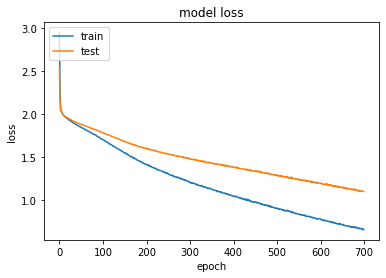

In [59]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [60]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [61]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk
accuracy: 57.22%


In [62]:
len(data3_df)

120

In [63]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)


  0%|          | 0/120 [00:00<?, ?it/s]

In [64]:
preds = loaded_model.predict(test_valid, batch_size=16, verbose=1)

8/8 [==============================] - 1s 14ms/step


In [65]:
preds

array([[4.50046867e-01, 1.61405616e-02, 4.31429654e-01, 1.33605488e-03,
        6.40538931e-02, 1.21910598e-05, 8.38380493e-03, 2.85969451e-02],
       [1.11568137e-03, 1.29300775e-03, 3.78976047e-01, 2.90930475e-04,
        6.17462218e-01, 6.46278859e-05, 7.95040862e-04, 2.50155654e-06],
       [1.65582553e-01, 6.38834026e-04, 4.83173609e-01, 8.07209685e-03,
        6.97017759e-02, 1.01389967e-04, 1.49096638e-01, 1.23633109e-01],
       [2.03858297e-02, 5.80251254e-02, 7.17186153e-01, 7.33315828e-04,
        6.95402734e-03, 2.95648879e-05, 1.87205315e-01, 9.48059931e-03],
       [2.72323057e-04, 1.46344248e-02, 8.96442413e-01, 3.12686129e-03,
        8.33347142e-02, 8.04418698e-04, 8.74118123e-04, 5.10637416e-04],
       [1.75014183e-01, 6.29423112e-02, 2.56029457e-01, 2.11959309e-03,
        4.81380165e-01, 3.06007169e-05, 1.44467759e-03, 2.10390799e-02],
       [3.39954123e-02, 6.47100015e-03, 8.93963456e-01, 1.85865778e-04,
        4.47930545e-02, 8.94277109e-05, 2.52660178e-03, 1.

In [66]:
preds1=preds.argmax(axis=1)

In [67]:
preds1

array([0, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 4, 4, 2, 0, 4, 0, 0, 0, 4, 2,
       4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 6, 4, 1, 4,
       4, 2, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 7, 7, 7, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 7, 7, 0, 3, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 4, 0, 0, 0], dtype=int64)

In [68]:
abc = preds1.astype(int).flatten()

In [69]:
predictions = (lb.inverse_transform((abc)))

In [70]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]


,predictedvalues
0,male_angry
1,male_happy
2,male_disgust
3,male_disgust
4,male_disgust
5,male_happy
6,male_disgust
7,male_disgust
8,male_disgust
9,male_happy


In [71]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))


In [72]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]


,actualvalues
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_calm
9,male_calm


In [73]:
finaldf = actualdf.join(preddf)

In [81]:
Audio_path = data3_df.path
finaldf = pd.concat([finaldf,Audio_path], axis=1)

In [85]:
finaldf[50:70]


,actualvalues,predictedvalues,path
50,male_disgust,male_disgust,data/Actor_21/03-01-07-02-02-01-21.wav
51,male_disgust,male_angry,data/Actor_21/03-01-07-02-02-02-21.wav
52,male_surprised,male_angry,data/Actor_21/03-01-08-01-01-01-21.wav
53,male_surprised,male_angry,data/Actor_21/03-01-08-01-01-02-21.wav
54,male_surprised,male_angry,data/Actor_21/03-01-08-01-02-01-21.wav
55,male_surprised,male_happy,data/Actor_21/03-01-08-01-02-02-21.wav
56,male_surprised,male_angry,data/Actor_21/03-01-08-02-01-01-21.wav
57,male_surprised,male_angry,data/Actor_21/03-01-08-02-01-02-21.wav
58,male_surprised,male_angry,data/Actor_21/03-01-08-02-02-01-21.wav
59,male_surprised,male_angry,data/Actor_21/03-01-08-02-02-02-21.wav


In [83]:
finaldf.to_csv('Predictions.csv', index=True)

In [87]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

In [88]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100


20.833333333333336

In [89]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100


12.59481975426248

In [90]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c


array([[15,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  1, 10,  0,  5,  0,  0,  0],
       [11,  0,  5,  0,  0,  0,  0,  0],
       [ 9,  1,  2,  1,  1,  0,  0,  2],
       [12,  0,  1,  0,  3,  0,  0,  0],
       [ 2,  0,  3,  0,  2,  0,  1,  0],
       [ 2,  1,  2,  0,  8,  0,  0,  3],
       [14,  0,  0,  0,  2,  0,  0,  0]], dtype=int64)

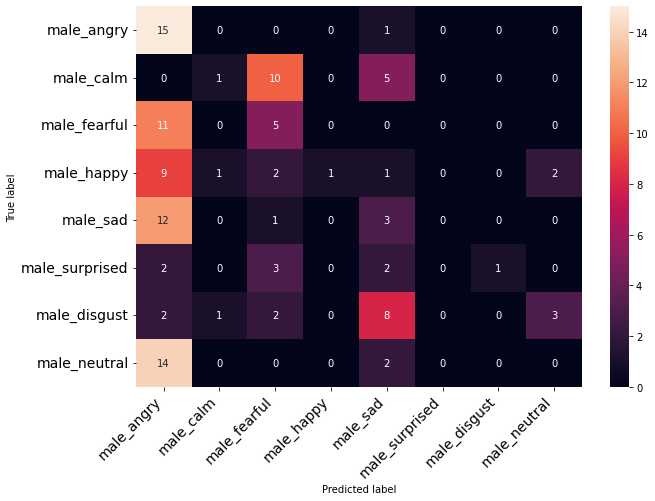

In [91]:
# Visualize Confusion Matrix 

class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad', 'male_surprised', 'male_disgust', 'male_neutral']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
# class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)


In [94]:
from pymongo import MongoClient
import pandas as pd



mongoclient = MongoClient()
db=mongoclient.adtproject
fetcheddata = db.predictedresults
df = pd.read_csv("Predictions.csv")
print(df)
predictedResults = df.to_dict(orient = 'records')
finalresult = db.predictedresults.insert_many(predictedResults)

     Unnamed: 0    actualvalues predictedvalues  \
0             0    male_neutral      male_angry   
1             1    male_neutral      male_happy   
2             2    male_neutral    male_disgust   
3             3    male_neutral    male_disgust   
4             4       male_calm    male_disgust   
..          ...             ...             ...   
115         115  male_surprised      male_angry   
116         116  male_surprised      male_happy   
117         117  male_surprised      male_angry   
118         118  male_surprised      male_angry   
119         119  male_surprised      male_angry   

                                       path  
0    data/Actor_21/03-01-01-01-01-01-21.wav  
1    data/Actor_21/03-01-01-01-01-02-21.wav  
2    data/Actor_21/03-01-01-01-02-01-21.wav  
3    data/Actor_21/03-01-01-01-02-02-21.wav  
4    data/Actor_21/03-01-02-01-01-01-21.wav  
..                                      ...  
115  data/Actor_23/03-01-08-01-02-02-23.wav  
116  data/Actor_23/